## Initial Analysis of Gulf Stream Cruise Data from Sept Cruise (Sept 4-9)

In [163]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime

#### Pull in CDOM data and ship TSG/GPS data

In [164]:
path = 'data/sept_cruise/wscd859/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=1)
    li.append(df_tmp)
cdom_df = pd.concat(li, axis=0, ignore_index=True)

cdom_df['utc_dt'] = pd.to_datetime(cdom_df['yyyy/mm/dd HH:MM:SS.fff'])

cdom_df = cdom_df.set_index('utc_dt')

df = pd.read_csv("data/sept_cruise/SW21011R_RFP/EventData/DataLogger/Data every 1 min_001.elg")
df.head()

Date      Time  SW-ZDA-Year  SW-ZDA-Month  SW-ZDA-Day  SW-ZDA-Time  \
0  09/04/2021  22:57:59         2021             9           4    230119.69   
1  09/04/2021  22:58:59         2021             9           4    230220.00   
2  09/04/2021  22:59:59         2021             9           4    230319.70   
3  09/04/2021  23:00:59         2021             9           4    230420.70   
4  09/04/2021  23:01:59         2021             9           4    230520.70   

   SW-GGA-Lat SW-GGA-NorS  SW-GGA-Long SW-GGA-EorW  ...  \
0   3438.0721           N    7639.5131           W  ...   
1   3437.7653           N    7639.3397           W  ...   
2   3437.4662           N    7639.1743           W  ...   
3   3437.1706           N    7639.0156           W  ...   
4   3436.8780           N    7638.8561           W  ...   

   SW-Weather-HumidRel-%  SW-Wind-WindSpeedRel  SW-Wind-WindAngleRel  \
0                   62.1                 23.70                346.29   
1                   62.6                 23.70                347.29   
2                   62.0                 19.98                344.39   
3                   63.8                 23.09                346.09   
4                   63.5                 23.38                348.79   

   TrueWind-DRV-SPEED  TrueWind-DRV-DIRECTION  TSG--temp-SBE38  TSG--sal  \
0                3.65                  137.98          26.5469   36.0464   
1                0.92                  120.30          26.5202   35.9130   
2                1.74                  100.41          26.7050   35.9890   
3                4.72                  123.35          26.7135   36.0296   
4                4.31                  152.50          26.8741   36.0758   

   SW-Depth-DBT-Depth below transducer (m)  DepthOverall-DRV-VALUE  \
0                                    15.57                   16.57   
1                                    16.51                   17.51   
2                                    16.34                   17.34   
3                                    16.23                   17.23   
4                                    16.52                   17.52   

   Unnamed: 24  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [165]:
# tsg_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/TSG/TSG-_20210904-222337.Raw', names=['DateTime', 'Temp','Sal','Unknown'], delim_whitespace=True)#sep=r"s*")# names=['Date', 'Time', 'Data'])
# tsg_df = tsg_df.drop('Unknown', 1)
# tsg_df.to_csv('sept_4_9_ship_data.csv')

In [166]:
tsg_df.head()

NameError: name 'tsg_df' is not defined

In [ ]:
# This first one is the right way to do this

In [ ]:
# date_time_strs = df['SW-ZDA-Year'].astype('str') + ' ' + df['SW-ZDA-Month'].astype('str') + ' ' + df['SW-ZDA-Day'].astype('str') + ' ' + df['SW-ZDA-Time'].astype('str').str[:-2].str.replace('.','')

# df['datetime'] = [datetime.strptime(x, '%Y %m %d %H%M%S') for x in date_time_strs]
# df['utc_dt'] = df['datetime']
# df  = df.set_index('utc_dt')

In [ ]:
date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')

In [ ]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

In [ ]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00'].plot()

### Pull in FCM Data

In [ ]:
fcm_df = pd.read_csv('data/sept_cruise/SW_fcm_full_bac_chla.csv')

In [ ]:
fcm_df

In [ ]:
date_time_strs = fcm_df['Date'] + ' ' + fcm_df['Time (UTC)']

fcm_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M') for x in date_time_strs]

In [ ]:
fcm_df['utc_dt'] = fcm_df['datetime']
fcm_df  = fcm_df.set_index('utc_dt')

In [ ]:
fcm_df.head()

In [ ]:
lats = []
lons = []
for i in range(len(fcm_df)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(fcm_df.iloc[i].datetime), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
fcm_df['lat'] = lats
fcm_df['lon'] = lons

In [ ]:
# fcm_df[['Sample#', 'datetime', 'lat', 'lon']].to_csv('sept_4_9_sample_time_loc.csv')

In [ ]:
fcm_gdf = gpd.GeoDataFrame(fcm_df, geometry=gpd.points_from_xy(fcm_df.lon, fcm_df.lat))

In [ ]:
fcm_gdf.columns

In [ ]:
start_times[i], end_times[i]

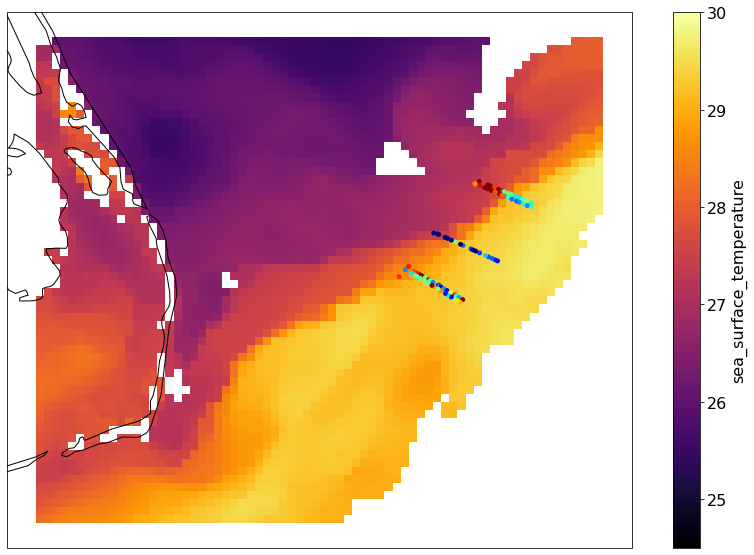

In [167]:
i=1
fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
goes_ds.sel(time=slice(pd.to_datetime(start_times[i])+timedelta(hours=1), pd.to_datetime(start_times[i])+timedelta(hours=2))).sea_surface_temperature[:,90:150, 110:180].mean(dim='time').plot(ax=ax, vmin=24.5, vmax=30, cmap='inferno')
# fig.savefig('sst_sept0523_studypoints.png',dpi=400)
# ax[1].set_title(titles[i] + ' zoom')
fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()

fcm_gdf.plot(ax=ax, markersize=15, column='Chla_Avg', vmin=.1,vmax=.25, cmap='jet')
# plt.savefig('sampling_locations_sept4-9.png',dpi=300)
plt.show()

<AxesSubplot:>

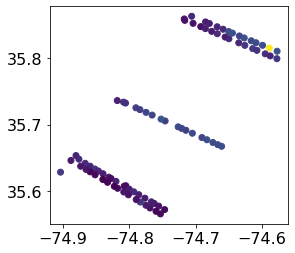

In [168]:
fcm_gdf.plot(column='PicoCyano_Avg')

### Pull in Profiles

In [215]:
import scipy
names = ['transect_0','transect_1', 'transect_2', 'transect_5', 'transect_6', 'transect_9']
li = []
for i, fn in enumerate(['data/VMP/Cruise2/VMPsurvey_051.mat','data/VMP/Cruise2/VMPsurvey_052.mat', 'data/VMP/Cruise2/VMPsurvey_053.mat', 'data/VMP/Cruise2/VMPsurvey_056.mat',
                       'data/VMP/Cruise2/VMPsurvey_057.mat', 'data/VMP/Cruise2/VMPsurvey_059.mat']):
    mat = scipy.io.loadmat(fn)
    for item in list(mat.keys()):
        if item not in ['__header__', '__version__', '__globals__']:
            df_tmp = pd.DataFrame(data=mat[item], columns=['time', 'depth (dBars)', 'temp (C)','salinity (PSU)', 'potential density (kg/m^3 -1000)', 
                                                    'chla (ppb)', 'turbidity (FTU)', 'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)'])
            df_tmp['transect'] = names[i]
            df_tmp['profile_num'] = int(item.split('profile')[-1])
            li.append(df_tmp)

profiles = pd.concat(li, axis=0, ignore_index=True)
profiles['dt'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles.time, unit='D') - pd.Timedelta(days=1)
profiles = profiles.set_index('dt')
profiles = profiles.sort_index(ascending=True)
profiles['datetime'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles.time, unit='D') - pd.Timedelta(days=1)

Define the interpolation function

In [239]:
import numpy as np
# from scipy.interpolate import interp2d
import scipy


data_variables = ['temp (C)', 'salinity (PSU)',
       'potential density (kg/m^3 -1000)', 'chla (ppb)', 'turbidity (FTU)',
       'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)']

def interpolate_profiles(df, transect, data_variables, plot=False):
    df_subset = df[df.transect == transect]
    interpolated_grids = []
    datetime_list = []
    for i in np.unique(df_subset.profile_num.values):
        datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
    datetime_list = np.array(datetime_list)
    datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
    
    # Original data (e.g. measurements)
    for data_var in data_variables:
        x_interp = np.arange(1,len(datetime_list), .5)
        y_interp = np.arange(-1,-115, -1)

        xx, yy = np.meshgrid(x_interp, y_interp)
        Z_table = df_subset[data_var].values

        Z = scipy.interpolate.griddata(np.array(list(zip(df_subset.profile_num.values , df_subset['depth (dBars)'].values ))), Z_table, (xx, yy), method='linear')

        datetime_list = []
        for i in np.unique(df_subset.profile_num.values):
            datetime_list.append(df_subset[df_subset.profile_num == i].head(1).datetime.values)
        datetime_list = np.array(datetime_list)
        datetime_strings = np.datetime_as_string(datetime_list.flatten(), unit='m')
        
        interpolated_grids.append(Z)

        if plot:
            fig, ax = plt.subplots(figsize=(12,7))
            im = ax.imshow(Z, aspect='auto', cmap='cividis')#vmax=22, vmin=26.4)

            cb = fig.colorbar(im)
            cb.set_label(data_var)

            ax.set(xticks=np.arange(0,np.max(df_subset.profile_num.values)*2-1,2), 
                   xticklabels=[x[6:].replace('T', ' ') for x in np.datetime_as_string(datetime_list.flatten(), unit='m')])

            ax.set_ylabel('Depth')
            ax.set_xlabel('Time (UTC)')
            fig.autofmt_xdate(rotation=45)
            ax.xaxis.set_major_locator(plt.MaxNLocator(15))

            # fig.savefig('transect6_profile_density.png')
            plt.show()
    return(datetime_list, interpolated_grids)

In [217]:
data_variables

['temp (C)',
 'salinity (PSU)',
 'potential density (kg/m^3 -1000)',
 'chla (ppb)',
 'turbidity (FTU)',
 'turb kinetic energy 1 (W/kg)',
 'turb kinetic energy 2 (W/kg)']

NameError: name 'df_subset' is not defined

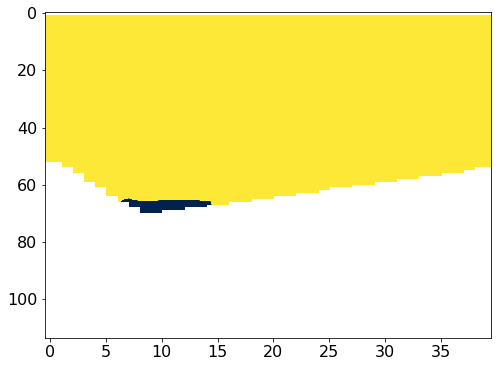

In [229]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(interpolated_grids[0],aspect='auto', cmap='cividis',vmax=30, vmin=20)

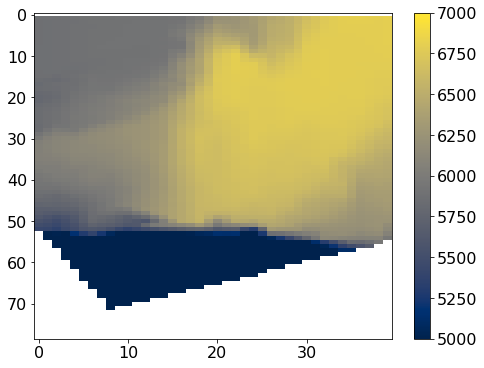

In [238]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(interpolated_grids[0],aspect='auto', cmap='cividis',vmax=7000, vmin=5000)
fig.colorbar(im)
fig.savefig('vmp_survey_51_temp_interp.png')

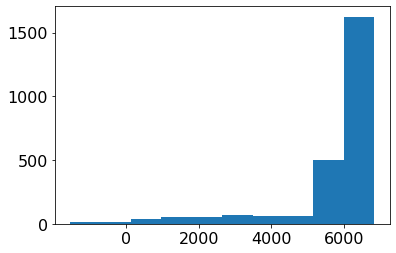

In [234]:
plt.hist(interpolated_grids[0].flatten())
plt.savefig('vmp_survey_51_temp_hist.png')

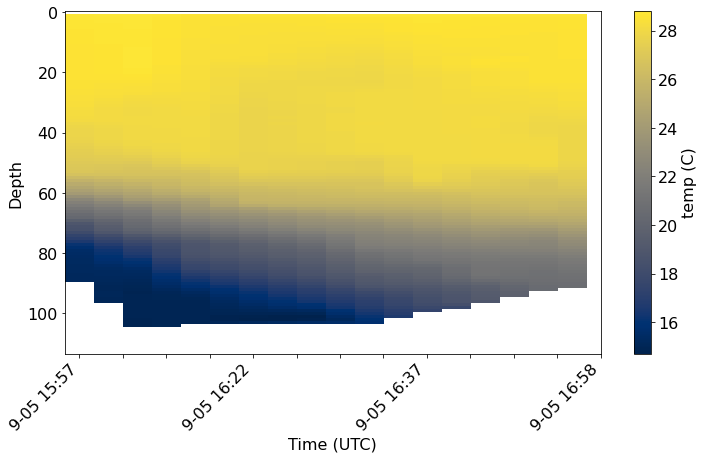

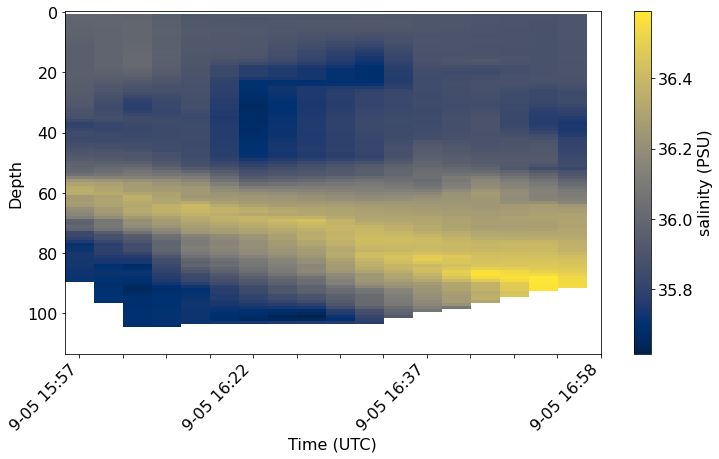

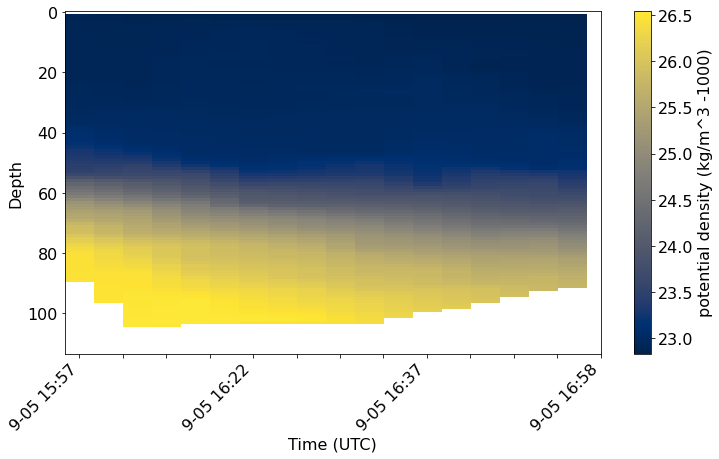

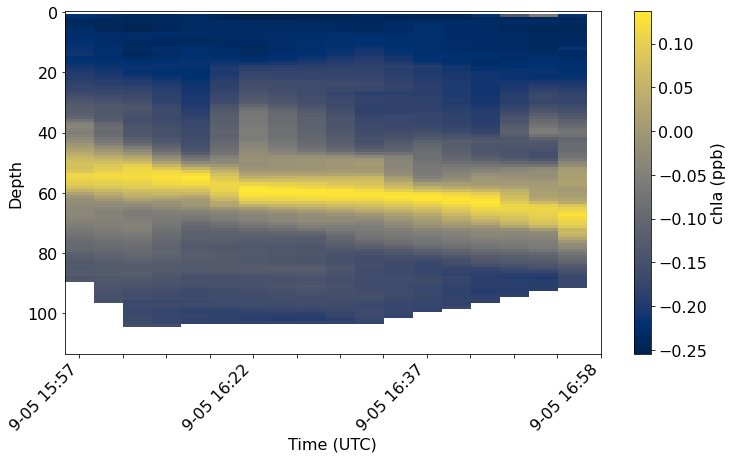

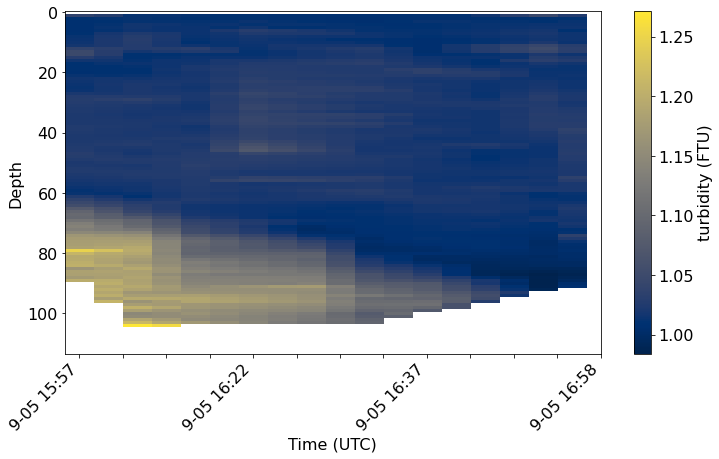

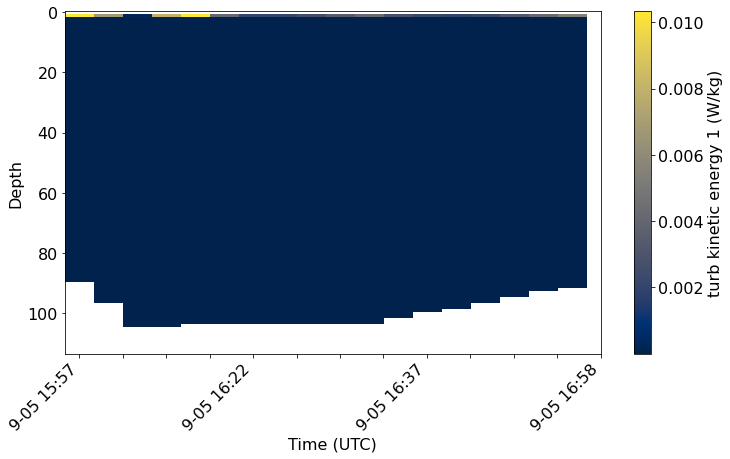

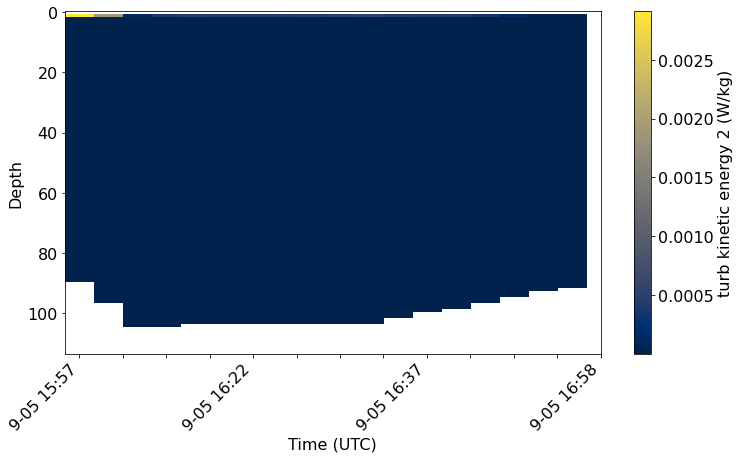

In [240]:
dates, interpolated_grids = interpolate_profiles(profiles, 'transect_1', data_variables, plot=True)

#### Visualizing SST from GOES

In [8]:
goes_ds = xr.open_dataset('data/jplStarG16SSTv270_8997_d932_2101.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [10]:
goes_ds.sea_surface_temperature[:,:, :].resample(time="6H", skipna=True).mean().hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

In [11]:
goes_ds.sea_surface_temperature[:,:, :].resample(time="1D", skipna=True).mean().hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

In [12]:
goes_ds.sea_surface_temperature[:,:, :].hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

<GeoAxesSubplot:title={'center':'time = 2021-08-19T04:00:00'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

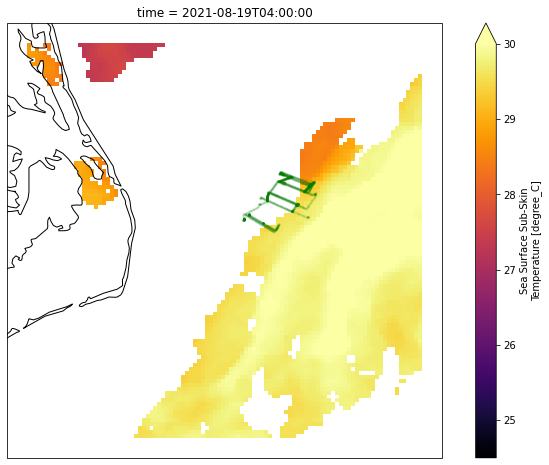

In [13]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
goes_ds.sea_surface_temperature[100,75:175, 100:200].plot(ax=ax, vmin=24.5, vmax=30, cmap='inferno')
gdf.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].plot(ax=ax, markersize=2, color='green', alpha=.05)
# fig.savefig('sst_sept0523_studypoints.png',dpi=400)

In [9]:
plt.rcParams.update({'font.size': 16})

### Visualizing the CDOM/Ship Data

In [17]:
# gdf.reset_index().drop(columns=['datetime', 'utc_dt']).to_file('compass_cruise.shp')

In [18]:
df.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

<ipython-input-10-df14b368788f>:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  cdom_df.loc['2021-09-5 11:00:00':'2021-09-9 18:30:00'].rolling(window=60).mean().plot(y=' V', ax=ax)


(0.05, 0.5)

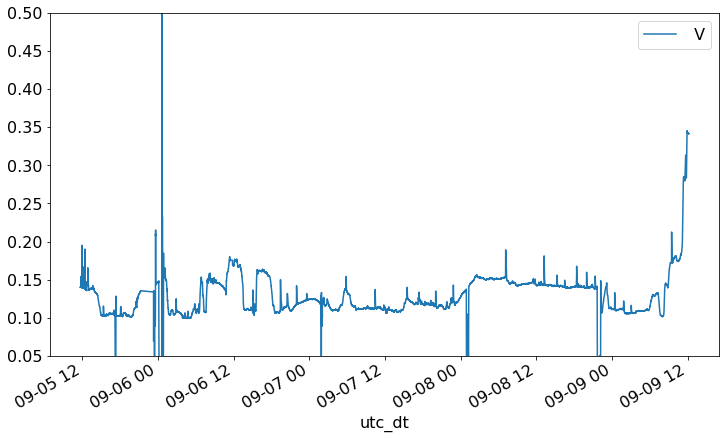

In [10]:
fig,ax = plt.subplots(figsize=(12,7))
cdom_df.loc['2021-09-5 11:00:00':'2021-09-9 18:30:00'].rolling(window=60).mean().plot(y=' V', ax=ax)
ax.set_ylim(0.05,.5)

In [20]:
df.loc['2021-09-5 13:00:00':'2021-09-5 17:30:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

## Working through each transect with data and SST

<GeoAxesSubplot:title={'center':'time = 2021-08-19T04:00:00'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

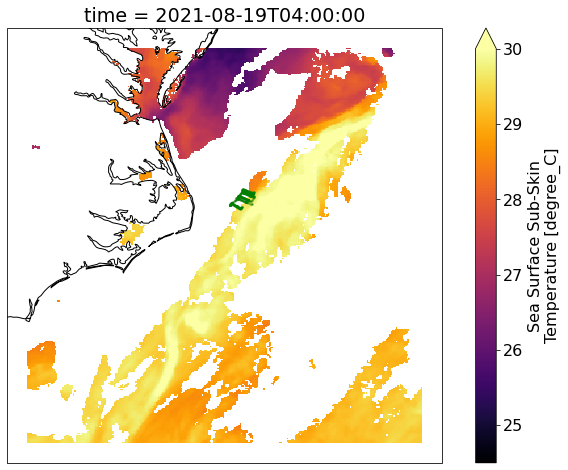

In [21]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
goes_ds.sea_surface_temperature[100,:, :].plot(ax=ax, vmin=24.5, vmax=30, cmap='inferno')
gdf.loc['2021-09-5 11:00:00':'2021-09-7 15:30:00'].plot(ax=ax, markersize=2, color='green', alpha=.05)
# fig.savefig('sst_sept0523_studypoints.png',dpi=400)

In [23]:
plt.rcParams.update({'font.size': 16})

In [36]:
fcm_df.columns

Index(['Sample#', 'Time (UTC)', 'Date', 'Syn/mL', 'A', 'B', 'Syn_Avg',
       'Peuks/mL', 'A.1', 'B.1', 'Peuks_Avg', 'PicoCyano/mL', 'A.2', 'B.2',
       'PicoCyano_Avg', 'datetime'],
      dtype='object')

In [140]:
fcm_df.Bacteria_Avg.min(), fcm_df.Bacteria_Avg.max()

(162573.0, 490518.5)

In [133]:
fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan

<ipython-input-133-a5003a0a14a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan


(0.0, 0.5)

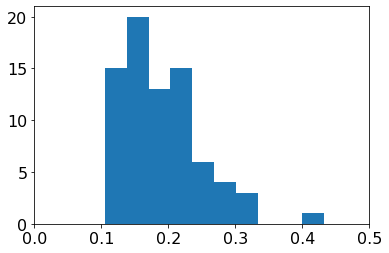

In [135]:
fig, ax = plt.subplots()
ax.hist(fcm_df.Chla_Avg)
ax.set_xlim(0,.5)

In [173]:
tn_names = ['transect_1', 'transect_2', 'transect_3', 'transect_4', 'transect_5', 'transect_6', 'transect_7', 'transect_8', 'transect_9']

In [241]:
# bad practice but they're too noisy
import warnings
warnings.filterwarnings("ignore")

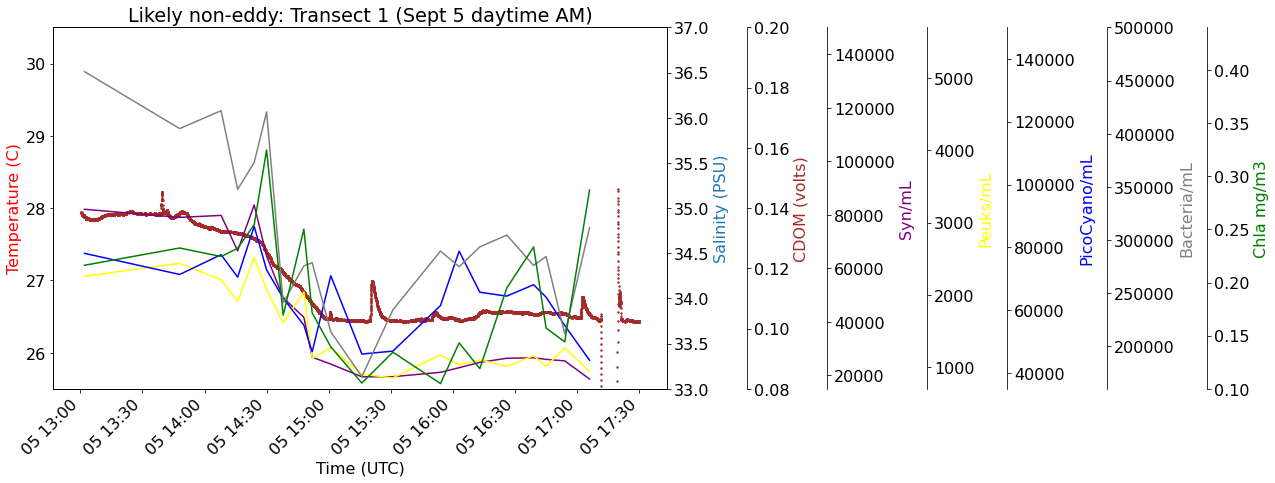

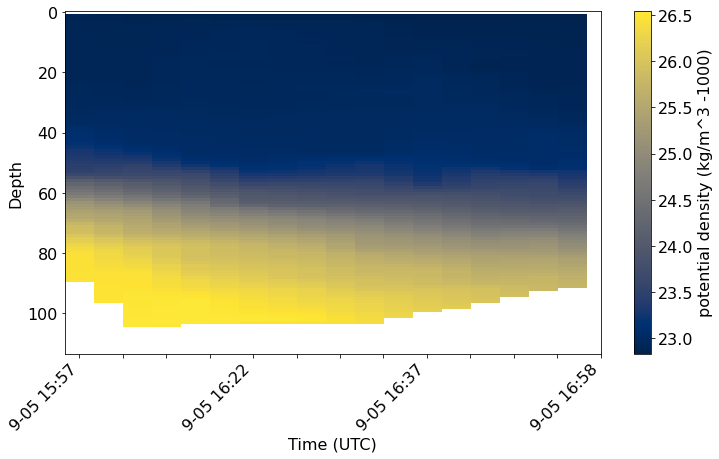

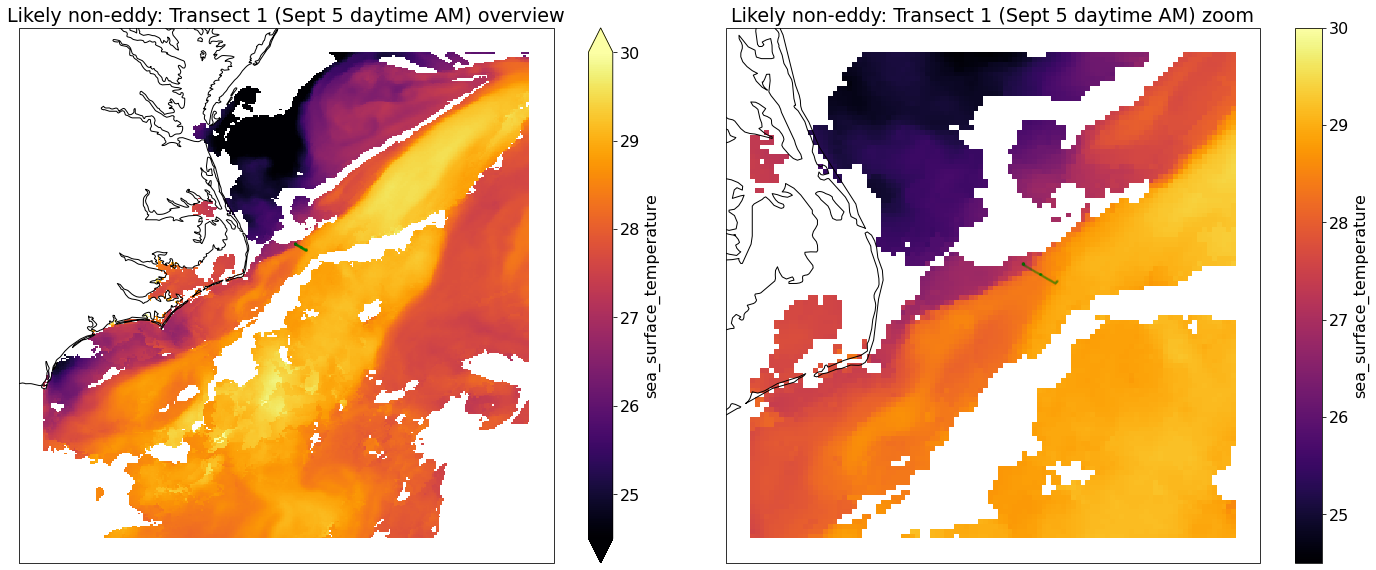

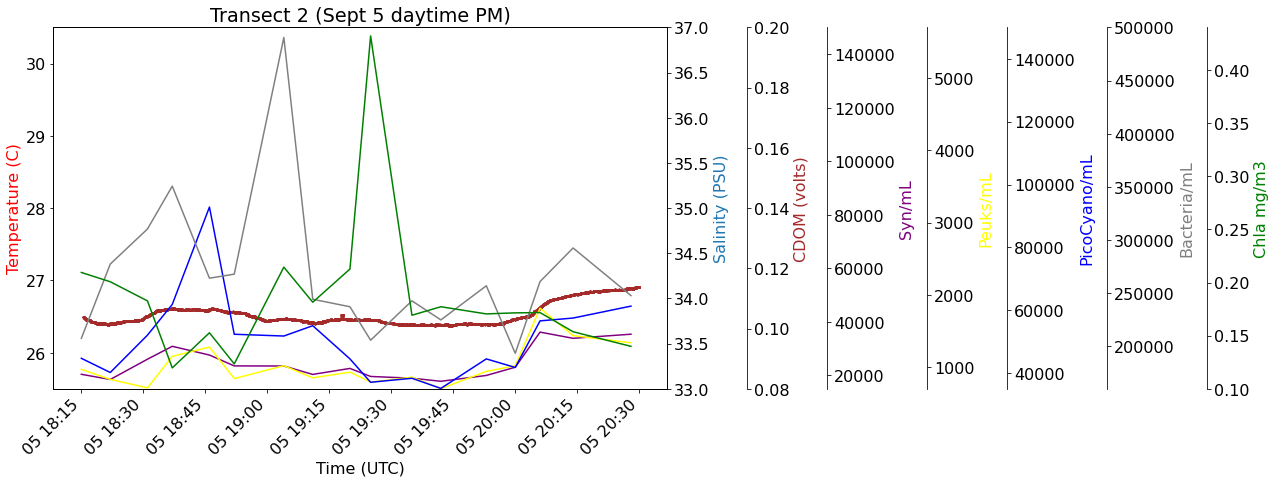

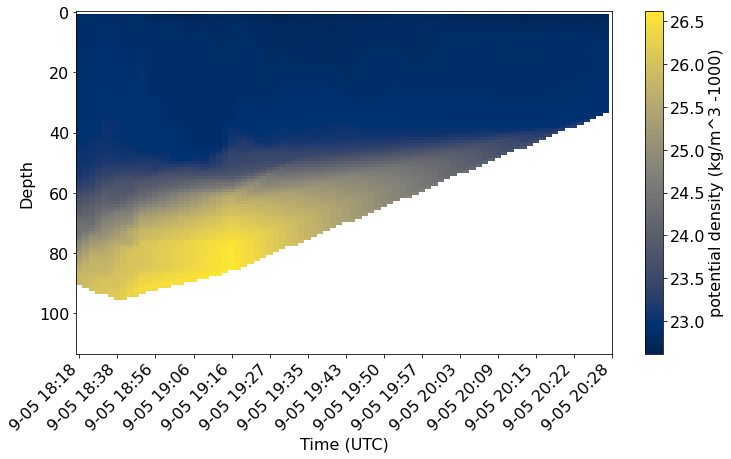

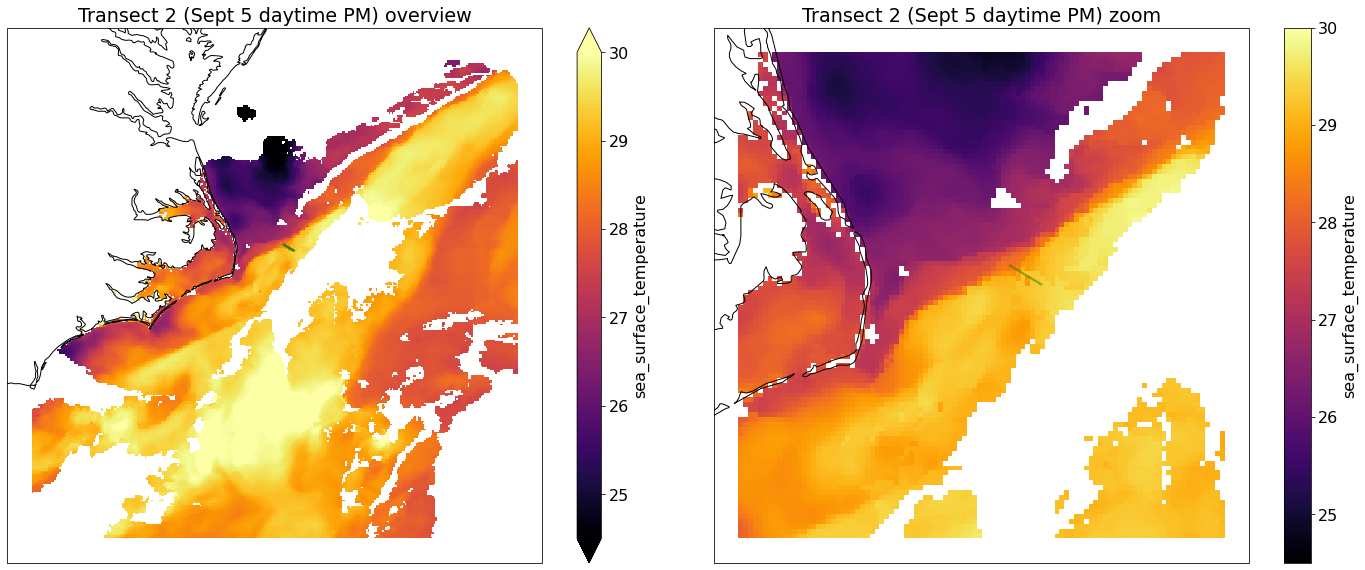

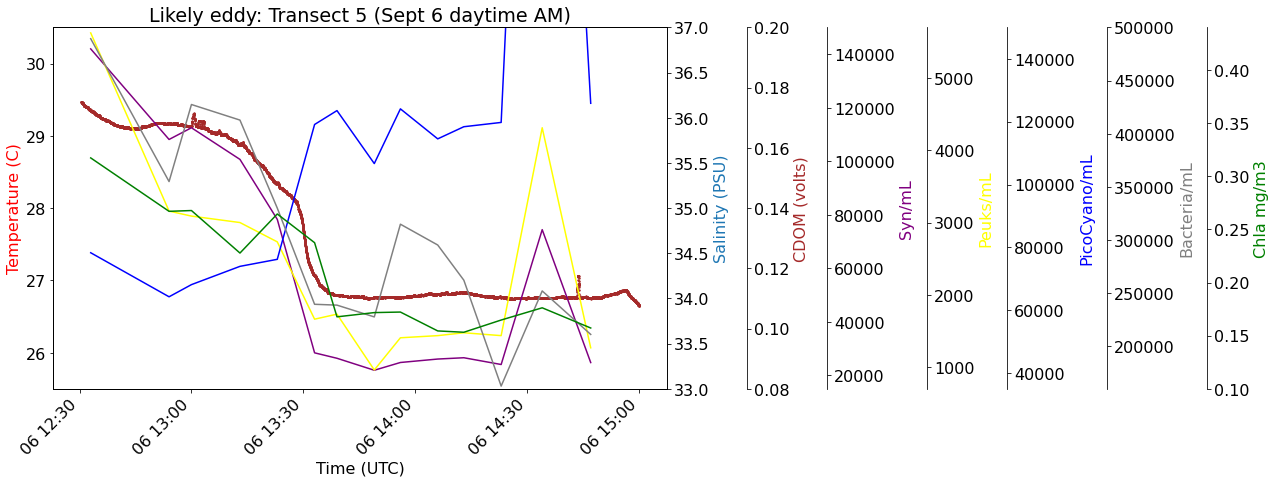

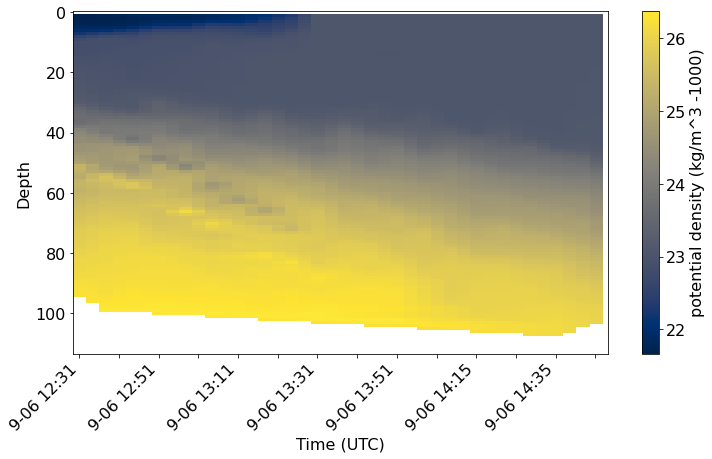

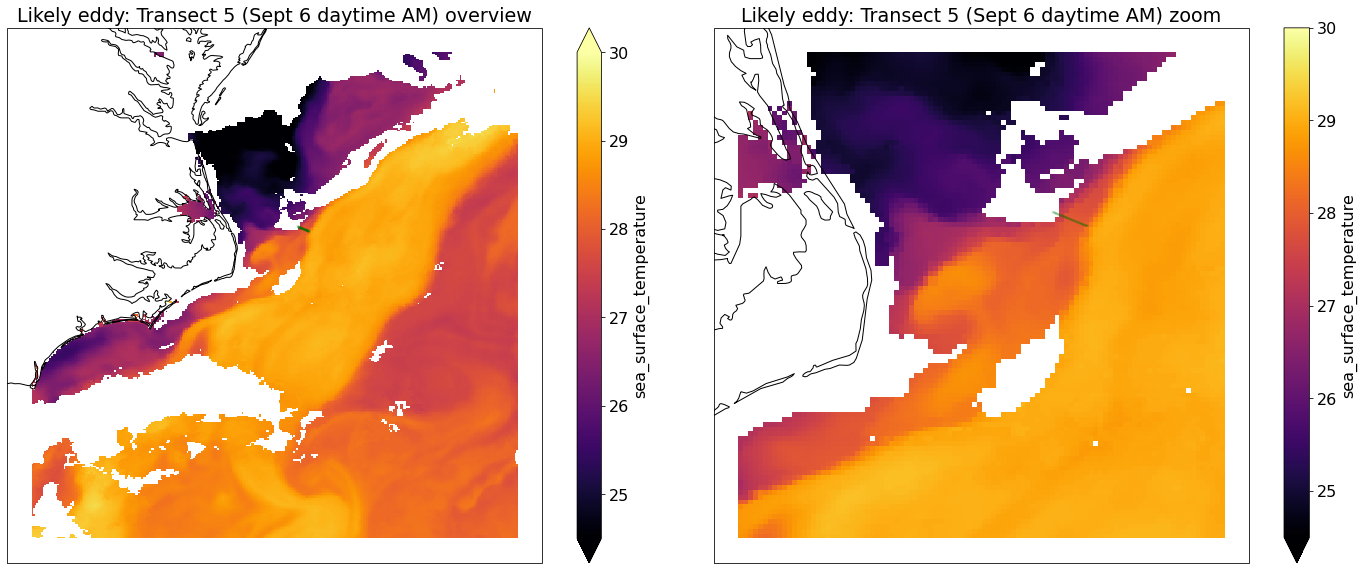

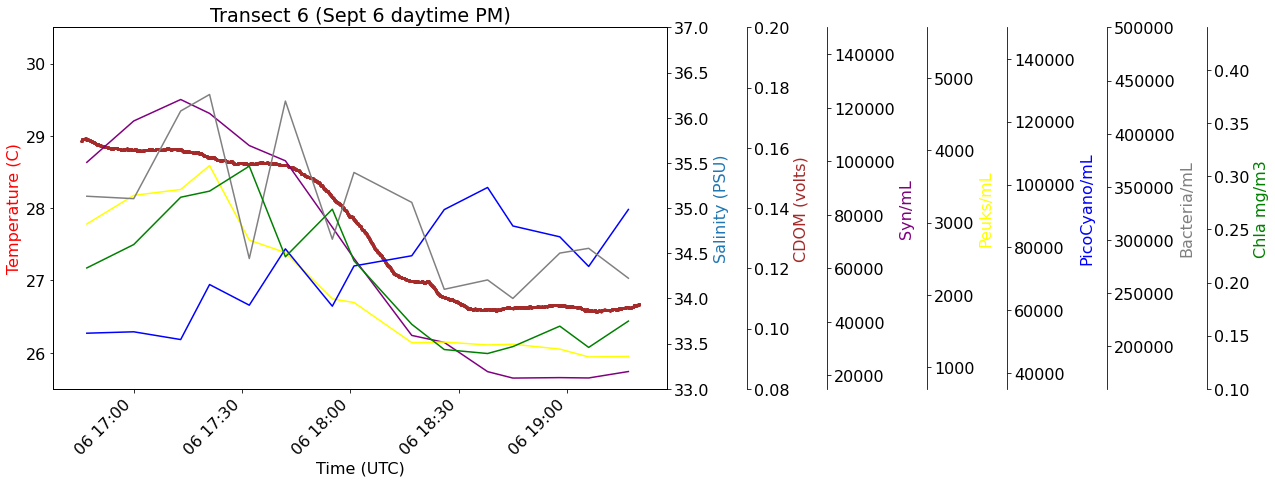

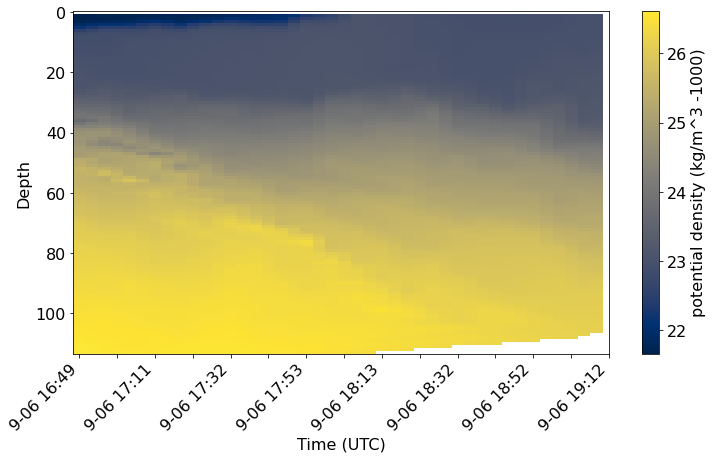

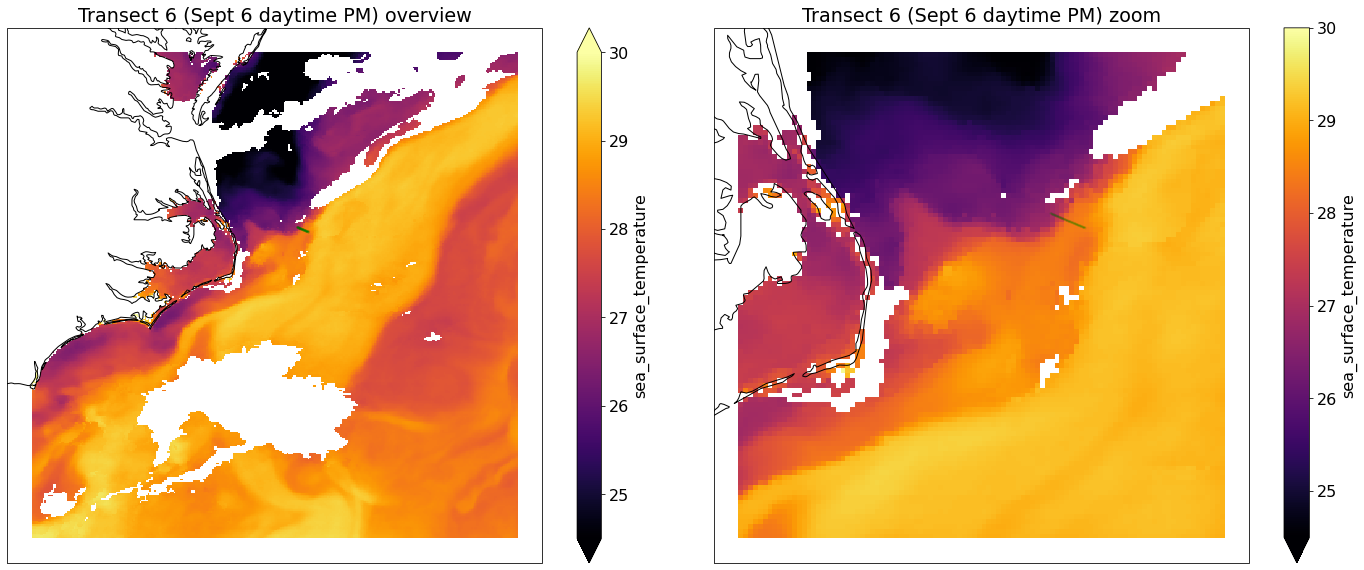

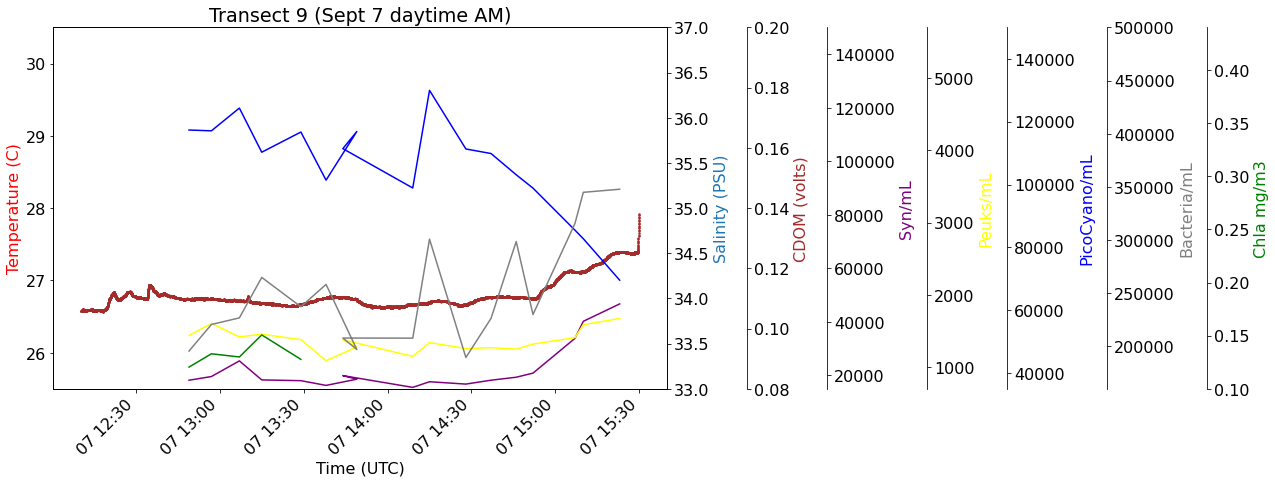

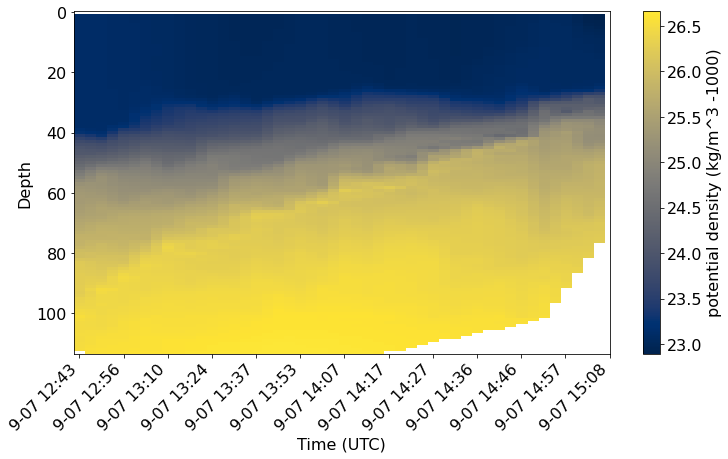

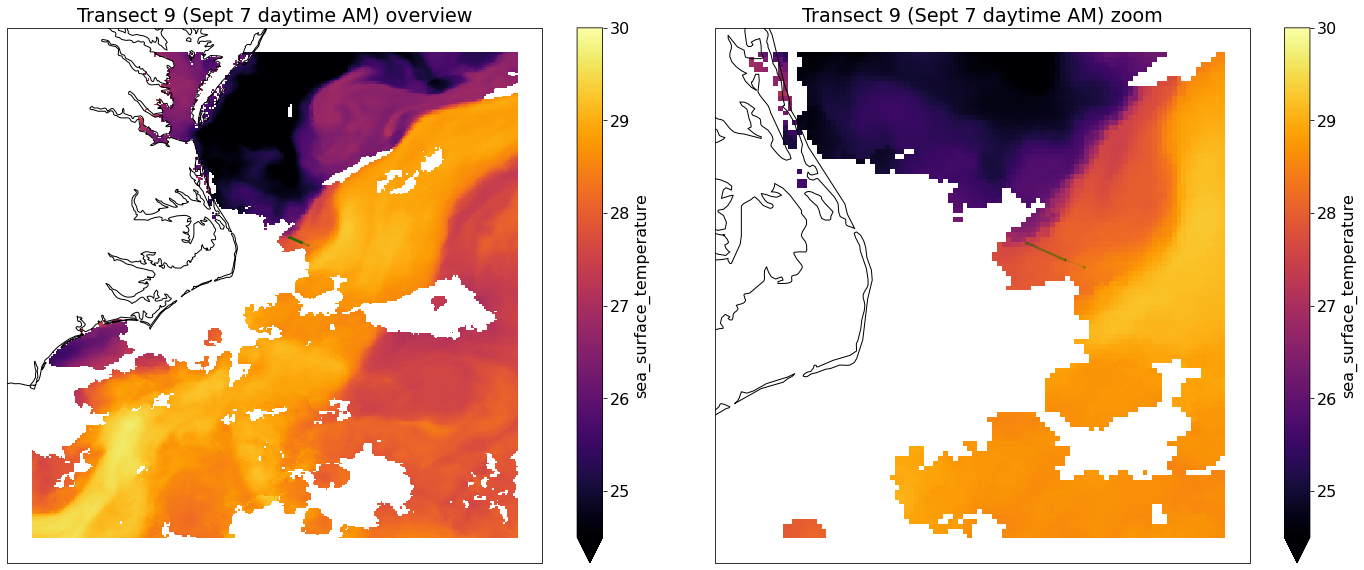

In [242]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']
hours = [0,0,0,0,0,0,0,0,0]

titles = ['Likely non-eddy: Transect 1 (Sept 5 daytime AM)', 'Transect 2 (Sept 5 daytime PM)', 'Transect 3 (Sept 5 nighttime)', 'Transect 4 (Sept 5 nighttime)', 
        'Likely eddy: Transect 5 (Sept 6 daytime AM)', 'Transect 6 (Sept 6 daytime PM)', 'Transect 7 (Sept 6 nighttime)', 'Transect 8 (Sept 6 nighttime)',
        'Transect 9 (Sept 7 daytime AM)']

for i in range(9):
    if fcm_df.loc[start_times[i]:end_times[i]]['Syn_Avg'].empty:
        pass
    else:
        # time series plot
        fig, ax = plt.subplots(figsize=(18,7))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()
        ax4 = ax.twinx()
        ax5 = ax.twinx()
        ax6 = ax.twinx()
        ax7 = ax.twinx()

        ax.set_ylim(25.5, 30.5)
        ax1.set_ylim(33, 37)
        ax2.set_ylim(.08, .2)
        ax3.set_ylim(15000, 150000)
        ax4.set_ylim(700, 5700)
        ax5.set_ylim(35000, 150000)
        ax6.set_ylim(160000, 500000)
        ax7.set_ylim(.1, .44)

        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax3.set_ylabel("Syn/mL")
        ax4.set_ylabel("Peuks/mL")
        ax5.set_ylabel("PicoCyano/mL")
        ax6.set_ylabel("Bacteria/mL")
        ax7.set_ylabel("Chla mg/m3")

        p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], color='red', label='Temp', lw=3)
        p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--sal'], label='Salinity', lw=3)
        p3 = ax2.scatter(cdom_df.loc[start_times[i]:end_times[i]].rolling(window=30).mean().index, cdom_df.loc[start_times[i]:end_times[i]].rolling(window=30).mean()[' V'], color='brown', label='CDOM', s=2)

        p4, = ax3.plot(fcm_df.loc[start_times[i]:end_times[i]].index, fcm_df.loc[start_times[i]:end_times[i]]['Syn_Avg'], label='Syn/mL', color='purple')
        p5, = ax4.plot(fcm_df.loc[start_times[i]:end_times[i]].index, fcm_df.loc[start_times[i]:end_times[i]]['Peuks_Avg'], label='Peuks/mL', color='yellow')
        p6, = ax5.plot(fcm_df.loc[start_times[i]:end_times[i]].index, fcm_df.loc[start_times[i]:end_times[i]]['PicoCyano_Avg'], label='PicoCyano/mL', color='blue')
        p7, = ax6.plot(fcm_df.loc[start_times[i]:end_times[i]].index, fcm_df.loc[start_times[i]:end_times[i]]['Bacteria_Avg'], label='Bacteria/mL', color='grey')
        p8, = ax7.plot(fcm_df.loc[start_times[i]:end_times[i]].index, fcm_df.loc[start_times[i]:end_times[i]]['Chla_Avg'], label='Chla mg/m3', color='green')    
        
        ax.set_title(titles[i])

        lns = [p1, p2, p3, p4,p5,p6,p7,p8]
        #ax.legend(handles=lns, loc='best')

        # right, left, top, bottom
        ax2.spines['right'].set_position(('outward', 80))
        ax3.spines['right'].set_position(('outward', 160))
        ax4.spines['right'].set_position(('outward', 260))
        ax5.spines['right'].set_position(('outward', 340))
        ax6.spines['right'].set_position(('outward', 440))
        ax7.spines['right'].set_position(('outward', 540))

        # no x-ticks                 
    #     ax2.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
        ax3.yaxis.label.set_color(p4.get_color())
        ax4.yaxis.label.set_color(p5.get_color())
        ax5.yaxis.label.set_color(p6.get_color())
        ax6.yaxis.label.set_color(p7.get_color())
        ax7.yaxis.label.set_color(p8.get_color())

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
        fig.savefig('figs/'+titles[i] +'.png')
    #     plt.close()
        plt.show()
        
        if i in [0,1,4,5,8]:        
            dates, interpolated_grids = interpolate_profiles(profiles, tn_names[i], ['potential density (kg/m^3 -1000)'], plot=True)



        # SST image

        fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
        ax[0].coastlines(resolution='10m')
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green', alpha=.05)

        ax[1].coastlines(resolution='10m')
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,75:175, 100:200].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.05)
        # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
        ax[0].set_title(titles[i] + ' overview')
        ax[1].set_title(titles[i] + ' zoom')
        fig.tight_layout()
    #     fig.savefig('figs/'+titles[i] +'sat_overview.png')
    #     plt.close()
        plt.show()

        # fig.savefig('transect' + str(i) '_s_t.png')